In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from scipy import sparse
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from asv_explainer import ASVExplainer
from pddshapley.sampling import IndependentConditioningMethod, GaussianConditioningMethod, \
    RandomSubsampleCollocation
from categorical_gaussian_conditioning_method import CategoricalGaussianConditioningMethod
from pddshapley import PartialDependenceDecomposition
from pddshapley.signature import FeatureSubset

# Training model

In [2]:
def get_data():
    # Load and concatenate data, we make our own train test split
    data = pd.read_csv('data/adult.data', header=None, index_col=None)
    data = data.reset_index(drop=True)
    #test_data = pd.read_csv('data/adult.test', header=None, index_col=None)
    #data = pd.concat([train_data, test_data])
    data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

    # Drop fnlwgt and education-num columns
    data = data.drop(columns=['fnlwgt', 'education-num'])
    return data.drop(columns=['income']), data['income']

In [3]:
X, y = get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [4]:
class CensusModel:
    def __init__(self):
        self.model = MLPClassifier(hidden_layer_sizes=(100, 100), verbose=True,
                                   early_stopping=True, validation_fraction=0.25)
        self.ohe_encoders = {}
        self.scalers = {}
        self.label_encoder = LabelEncoder()
    
    def preprocess(self, X, y=None):
        arrays = []
        if hasattr(X, "columns"):
            X = X.values
        for i, key in enumerate(self.columns):
            col = X[:, i].reshape(-1, 1)
            if key in self.categorical_columns:
                arrays.append(self.ohe_encoders[key].transform(col))
            elif key in self.numerical_columns:
                arrays.append(self.scalers[key].transform(col))
            else:
                raise ValueError(f"Unknown column {key}")
        X = sparse.hstack(arrays).toarray()
        if y is not None:
            y = self.label_encoder.transform(y)
            return X, y
        return X
    
    def fit(self, X, y):
        self.categorical_columns = X.select_dtypes(include=['object']).columns
        self.numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
        self.columns = X.columns

        # Fit preprocessors
        for key in self.categorical_columns:
            self.ohe_encoders[key] = OneHotEncoder()
            self.ohe_encoders[key].fit(X[[key]].values)
        for key in self.numerical_columns:
            self.scalers[key] = StandardScaler()
            self.scalers[key].fit(X[[key]].values)
        self.label_encoder.fit(y)

        # Preprocess
        X, y = self.preprocess(X, y)

        # Fit model
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(self.preprocess(X))

    def predict_proba(self, X):
        return self.model.predict_proba(self.preprocess(X))

In [5]:
mlp = CensusModel()
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.41224499
Validation score: 0.844554
Iteration 2, loss = 0.31469035
Validation score: 0.849140
Iteration 3, loss = 0.30519188
Validation score: 0.845864
Iteration 4, loss = 0.30134567
Validation score: 0.849468
Iteration 5, loss = 0.29870788
Validation score: 0.850942
Iteration 6, loss = 0.29433079
Validation score: 0.853890
Iteration 7, loss = 0.29285893
Validation score: 0.849140
Iteration 8, loss = 0.28835990
Validation score: 0.849795
Iteration 9, loss = 0.28495902
Validation score: 0.850942
Iteration 10, loss = 0.28285352
Validation score: 0.854218
Iteration 11, loss = 0.27960531
Validation score: 0.850450
Iteration 12, loss = 0.27886500
Validation score: 0.849468
Iteration 13, loss = 0.27528530
Validation score: 0.845536
Iteration 14, loss = 0.27238828
Validation score: 0.849304
Iteration 15, loss = 0.26919713
Validation score: 0.844717
Iteration 16, loss = 0.26661387
Validation score: 0.848976
Iteration 17, loss = 0.26286033
Validation score: 0.849140
Iterat

In [6]:
print(f"Train bal acc: {balanced_accuracy_score(LabelEncoder().fit_transform(y_train), mlp.predict(X_train)):.3f}")
print(f"Test bal acc: {balanced_accuracy_score(LabelEncoder().fit_transform(y_test), mlp.predict(X_test)):.3f}")

Train bal acc: 0.789
Test bal acc: 0.778


# Computing ASVs using permutations
Off-manifold

In [7]:
if False:
    independent_explainer = ASVExplainer(mlp.predict, IndependentConditioningMethod(X_train.sample(50)), 1)
    symmetric_independent = independent_explainer.explain(X_test.sample(100).values, num_permutations=10)
    df = pd.DataFrame(symmetric_independent[..., 0], columns=X_test.columns)
    df.abs().mean().sort_values(ascending=False).plot.bar()

On-manifold

100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


<Axes: >

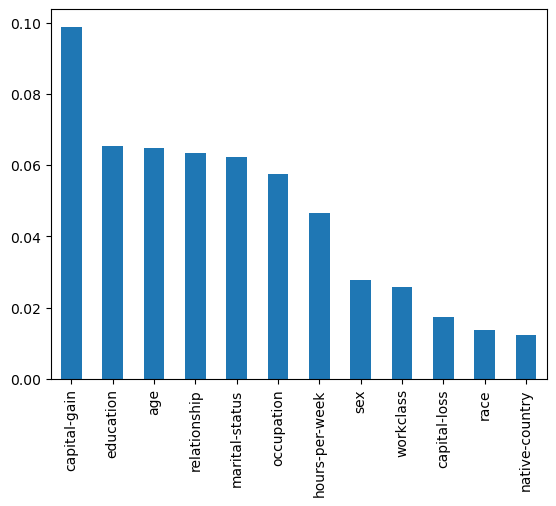

In [8]:
categorical_features = FeatureSubset(
    *[i for i, key in enumerate(X_train.columns) if key in mlp.categorical_columns])
conditioning = CategoricalGaussianConditioningMethod(X_train.values, categorical_features)
manifold_explainer = ASVExplainer(mlp.predict_proba, conditioning, 2)
symmetric_on_manifold = manifold_explainer.explain(X_test.sample(100).values, num_permutations=10)
df = pd.DataFrame(symmetric_on_manifold[..., 0], columns=X_test.columns)
df.abs().mean().sort_values(ascending=False).plot.bar()

100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


<Axes: >

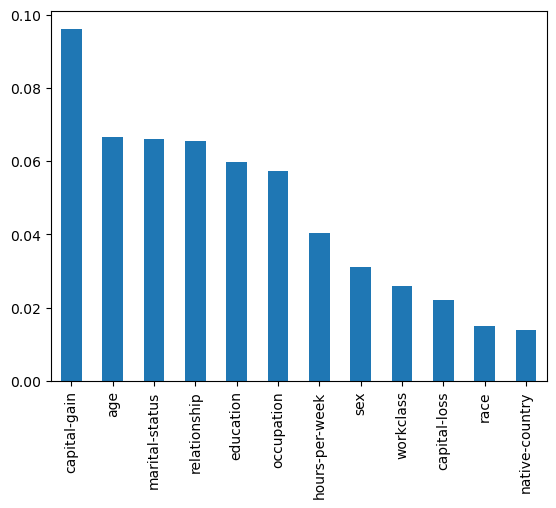

In [14]:
predecessors = ["age" , "sex", "native-country", "race"]
partial_order = [
    predecessors,
    [c for c in X_train.columns if c not in predecessors]
]
po_idx = [[list(X_train.columns).index(key) for key in p] for p in partial_order]

asymmetric = manifold_explainer.explain(X_test.sample(100).values, num_permutations=10, partial_order=po_idx)
df = pd.DataFrame(asymmetric[..., 0], columns=X_test.columns)
df.abs().mean().sort_values(ascending=False).plot.bar()